## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

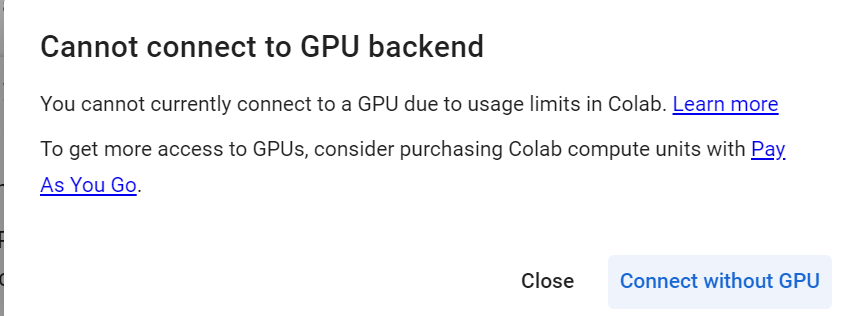

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock_news = pd.read_csv('/content/drive/MyDrive/PG_AIML/NLP/Project_StockSentimentAnalysis/stock_news.csv')

In [ ]:
# create a copy of the stock news data
data = stock_news.copy()

## **Data Overview**

### Displaying the first few rows of the dataset

In [ ]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### Understanding the shape of the dataset

In [ ]:
data.shape

(349, 8)

- 349 rows and 8 columns.

### Checking the data types of the columns

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


- Date column is an object type. We can convert it to date format for easy processing.

In [ ]:
# convert to datetime format
data['Date'] = pd.to_datetime(data['Date'])

### Checking the statistical summary

In [ ]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.0,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


- Based on Date column min and max values, this dataset has around 4 months of data.

### Checking the duplicate values

In [ ]:
data.duplicated().sum()

0

- No duplicates.

### Checking for missing values

In [ ]:
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


- No missing values.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Label

<Axes: xlabel='Label', ylabel='percent'>

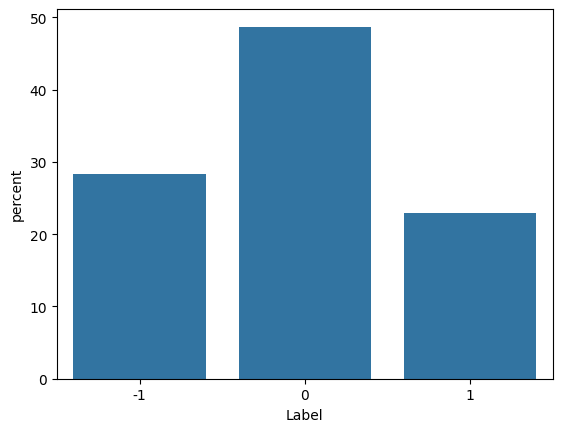

In [ ]:
sns.countplot(data=data, x="Label", stat="percent")

- Neutral sentiment (Label 0) news percentage is the highest at around 50%.
- Negative (Label -1) and Positive (Label 1) sentiment news percentage is around 25% each.

#### Density Plot of Price (Open, High, Low, Close)

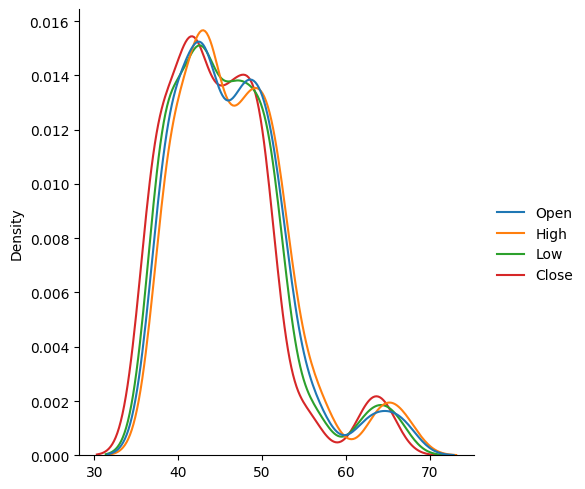

In [ ]:
sns.displot(data=data[['Open', 'High', 'Low', 'Close']], kind="kde", palette="tab10")

- All 4 price types show right skewness in the distribution.
- Most frequent value for all 4 price types is around $42.
- All 4 price types overlap which shows a strong correlation.
- There are no outliers in all 4 price types.


#### Volume

<Axes: xlabel='Volume', ylabel='Count'>

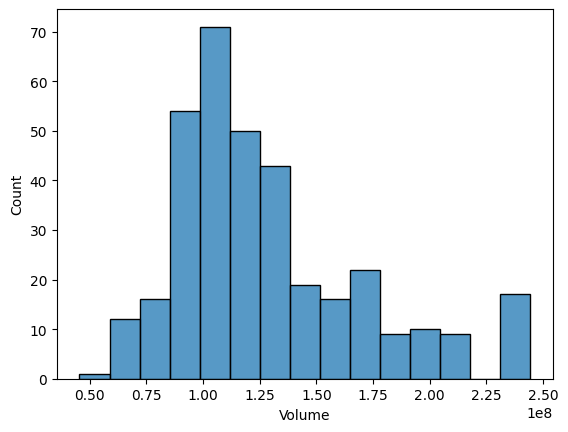

In [ ]:
sns.histplot(data, x="Volume")

- Lowest volume of ~0.50e8 were traded for less than 5 days each.
- Highest volume of ~2.35e8 were traded for around 20 days each.

#### News

In [ ]:
# calculate the total number of words present in the news content.
data['News_Length'] = data['News'].apply(lambda x: len(x.split(' ')))

In [ ]:
data['News_Length'].describe()

,News_Length
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


- The average word count in the news column is ~49 words.
- Maximum word count seen is 61, and minimum seen is 19.

<Axes: xlabel='News_Length', ylabel='Count'>

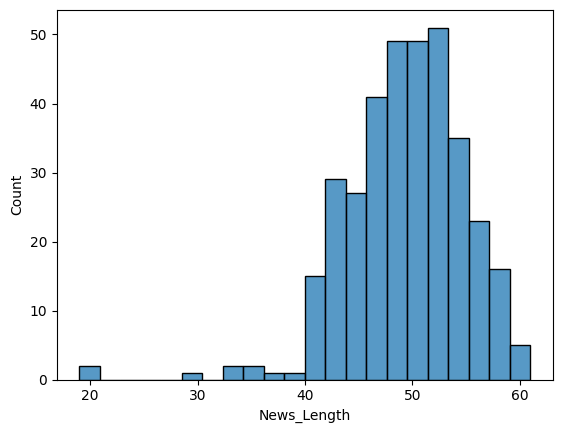

In [ ]:
sns.histplot(data=data, x="News_Length")

- Rows with news of around 20 words is less than 5.
- Rows with news of around 60 words is around 5.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

<Axes: >

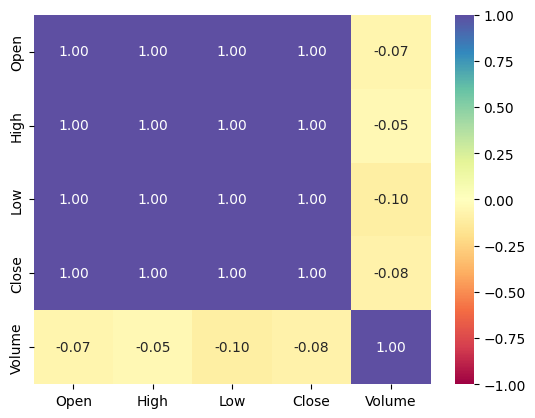

In [ ]:
sns.heatmap(data[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")

- Columns 'Open', 'High', 'Low', 'Close' has perfect correlation between each other.


#### Label vs Price (Open, High, Low, Close)

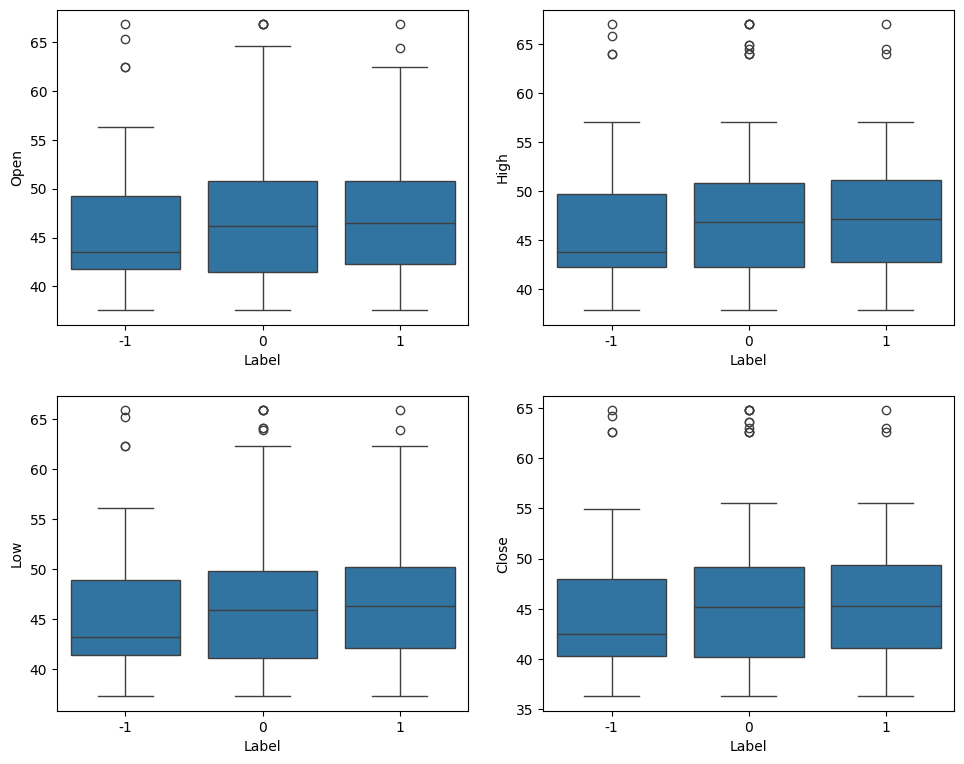

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* Label data shows similar pattern for all 4 price types.
* Mean price for Negative sentiment (Label -1) is around 43.
* Mean price for Positive sentiment (Label 1) is around 47.
* Mean price for Neutral sentiment (Label 0) is around 46.


#### Label vs Volume

<Axes: xlabel='Label', ylabel='Volume'>

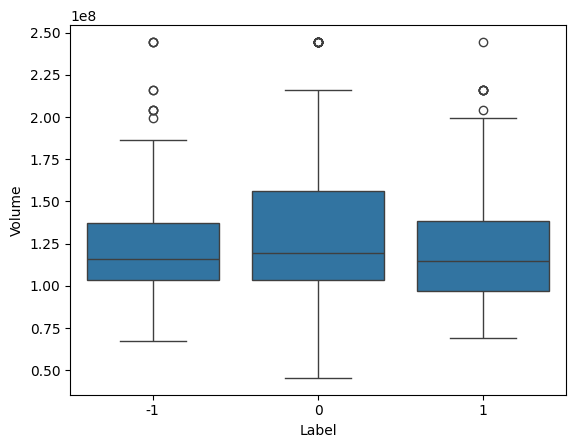

In [ ]:
sns.boxplot(data=data, x="Label", y="Volume")

- Largest range in volume of trades are under Neutral sentiment (Label 0).

#### Date vs Price (Open, High, Low, Close)

In [ ]:
stock_daily = data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'data' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


<Axes: xlabel='Date'>

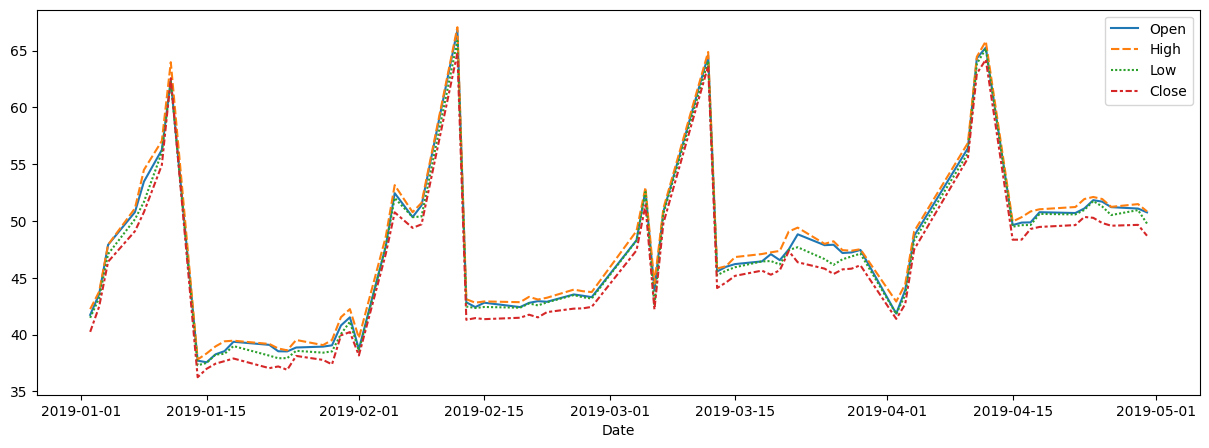

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(stock_daily.drop("Volume", axis=1))

- Stock price follows a pattern here where the price starts climbing higher from the start of the month and reach the peak before mid-month.
- By mid-month there is steep drop in the price and then it stays almost flat till the end of the month.

#### Volume vs Close Price

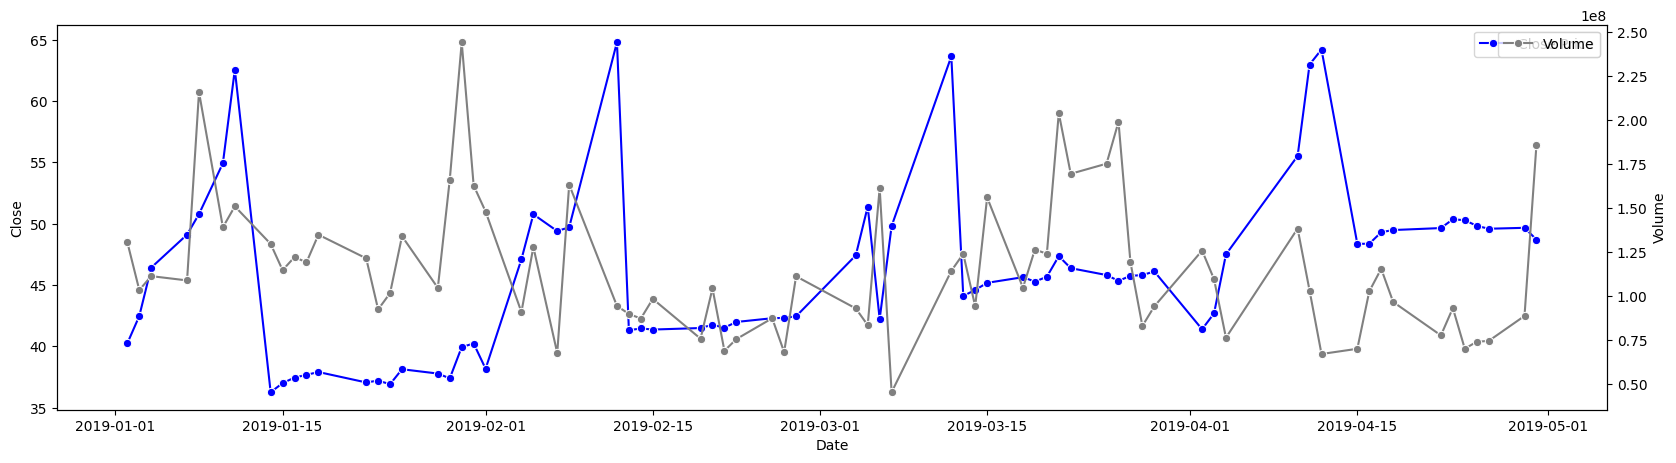

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

- The Close Price peaks some days after the Volume of trade peaks for the month.

## **Data Preprocessing**

### Train-Test-Validation Split

In [ ]:
data['Date'].describe().T

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


In [ ]:
X_train = data[(data['Date'] < '2019-04-01 00:00:00')].reset_index()    # All rows where the 'Date' is before '2019-04-01'
X_val = data[(data['Date'] >= '2019-04-01 00:00:00') & (data['Date'] < '2019-04-16 00:00:00')].reset_index()    # All rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = data[data['Date'] >= '2019-04-16 00:00:00'].reset_index()    # All rows where the 'Date' is from '2019-04-16' till the end

In [ ]:
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [ ]:
# print the shape of X_train, X_val, X_test, y_train, y_val and y_test
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

print("Train label shape:", y_train.shape)
print("Validation label shape:", y_val.shape)
print("Test label shape:", y_test.shape)

Train data shape: (286, 9)
Validation data shape: (21, 9)
Test data shape: (42, 9)
Train label shape: (286,)
Validation label shape: (21,)
Test label shape: (42,)


## **Word Embeddings**

### Word2Vec

In [ ]:
# Create a list of all words in our data
words_list = [item.split(" ") for item in data['News'].values]

In [ ]:
# Create an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Check the size of the vocabulary
print("Length of the vocabulary is:", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is: 4682


**Let's find a few word embeddings obtained using the model.**

In [ ]:
# Check the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-4.20215726e-03,  3.77450734e-02,  8.25903565e-03,  1.15630692e-02,
        1.33209047e-03, -5.74677698e-02,  2.87809018e-02,  8.75672027e-02,
        3.82067054e-03, -2.19544508e-02,  6.06565410e-03, -2.09595729e-02,
       -4.74659447e-03,  1.49979917e-02, -2.56427452e-02, -2.71111336e-02,
        2.32518334e-02, -4.17098822e-03,  6.58014230e-03, -2.48471312e-02,
       -2.28858553e-02,  7.97384605e-03,  2.93953195e-02,  1.48528079e-02,
        2.43794620e-02,  6.69310335e-04, -3.55172530e-02,  8.67386628e-03,
       -2.86695044e-02, -4.12873439e-02,  9.96900722e-03, -2.73434054e-02,
        4.79571288e-03, -8.71155970e-03, -1.52867648e-03,  2.31782254e-02,
        1.24527924e-02, -3.44422720e-02, -2.53995671e-03, -1.24707194e-02,
       -2.01517586e-02,  3.67871881e-03, -7.61826159e-05, -2.06698030e-02,
        2.00479869e-02,  3.81013788e-02,  8.87924992e-03,  1.77673195e-02,
        1.51101092e-04,  2.34596767e-02,  1.17916754e-02, -9.23041534e-03,
       -2.08105594e-02,  

In [ ]:
# Check the word embedding of a random word
word = "buy"
model_W2V.wv[word]

array([-8.92068958e-04,  6.90159679e-04,  2.02832052e-05,  8.23399387e-06,
        1.43016817e-03, -7.03132106e-03,  1.31007808e-03,  7.08525209e-03,
       -3.59021215e-07, -2.16734456e-03, -2.33321986e-03, -1.87380461e-03,
        7.17917748e-04,  4.11975384e-03, -7.11771601e-04, -3.12463241e-03,
        1.59528805e-04, -1.54866872e-03,  8.65471317e-04, -4.85695433e-03,
       -2.35535670e-03, -1.38790882e-03,  2.28764582e-03,  5.65071299e-04,
        2.56089657e-03,  2.46253586e-03, -3.23337759e-03, -5.51600999e-04,
       -4.47635911e-03, -4.63440130e-03,  2.94622197e-03, -4.45072306e-03,
        3.44768353e-03, -2.91846530e-03,  2.04386306e-03,  7.10967433e-05,
       -2.09550001e-03,  7.36069051e-04,  7.31262320e-04,  1.31669641e-03,
       -2.16125441e-03, -2.57431343e-03, -6.75037736e-04, -1.44981081e-03,
        1.26127200e-03, -2.68149044e-04,  2.53235176e-03,  3.08976392e-03,
       -1.48622508e-04,  4.68261447e-03,  3.96513520e-03, -4.12241614e-04,
        7.04138132e-04,  

In [ ]:
# Retrieve the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieve word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Create a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Create a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken:', (end - start))

Time taken: 0.4981389045715332


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

In [ ]:
# Load the Stanford GloVe model
filename = '/content/drive/MyDrive/PG_AIML/NLP/Project_StockSentimentAnalysis/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Check the size of the vocabulary
print("Length of the vocabulary is:", len(glove_model.index_to_key))

Length of the vocabulary is: 400000


**Let's check a few word embeddings using this model**

In [ ]:
# Check the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Check the word embedding of a random word
word = "buy"
glove_model[word]

array([ 3.6204e-01,  4.3627e-01,  1.0537e-01, -7.2283e-02, -1.8659e-02,
       -2.9907e-01, -1.6831e-01, -1.8568e-01, -1.4917e-02,  1.2401e-01,
        4.7516e-01,  2.9193e-01, -3.4240e-01, -1.5473e-01, -7.8222e-02,
       -7.6945e-01,  4.4412e-01,  5.2212e-01,  2.5644e-01,  5.1775e-01,
        2.1418e-01,  1.3528e-01,  2.6416e-02,  4.8589e-02, -2.5300e-01,
       -2.3770e-01, -3.6071e-01, -5.1730e-01, -5.3779e-01,  1.0609e-01,
        2.4107e-01,  1.2327e+00, -6.6713e-01, -4.8634e-01,  4.0379e-01,
        9.1192e-01,  6.5898e-01, -2.5026e-01,  2.5392e-01, -6.7397e-01,
        8.2783e-01, -3.0939e-01, -6.0350e-01, -1.1522e+00, -5.7824e-01,
        3.0718e-01, -7.2217e-01, -2.9964e-01, -2.5658e-01, -1.1173e+00,
       -1.2917e-01,  6.6389e-01,  1.9588e-01,  1.9904e-01,  1.3513e-02,
       -2.1723e+00, -2.1812e-01, -2.2405e-01,  2.1573e+00, -6.4404e-01,
        5.9759e-01,  4.6857e-01, -1.4556e-01,  6.9229e-02,  1.5082e-01,
       -3.8374e-02,  5.8870e-01,  9.0636e-01,  2.2438e-04, -4.45

In [ ]:
# Retrieve the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Create a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken:', (end - start))

Time taken: 34.481175661087036


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

In [ ]:
# Define the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# set the device to GPU if available, else set as CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken:",(end - start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken: 2.0325889587402344


In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


- Each of the news content is converted to a 384-dimensional vector based on the *all-MiniLM-L6-v2* model.

## **Sentiment Analysis**

### Model Evaluation Criteria

- Model should be able to evaluate and identify positive, neutral and negative sentiment with equal importance as each can impact the stock price in different ways.
- We will be comparing the F1 score of the models to find the best model here as it provides a balanced model.

### Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [ ]:
# Build the model
base_wv = RandomForestClassifier(random_state=42)

# Fit on training data
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

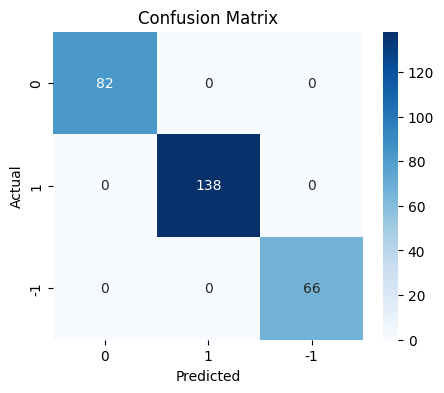

In [ ]:
plot_confusion_matrix(base_wv, X_train_wv, y_train)

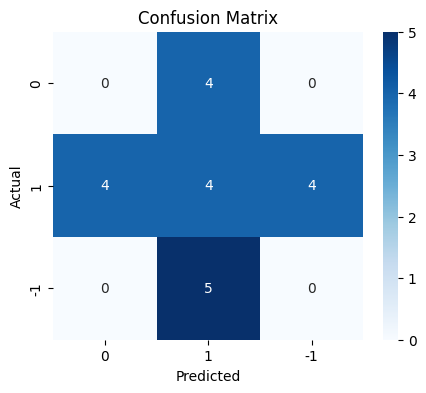

In [ ]:
plot_confusion_matrix(base_wv, X_val_wv, y_val)

In [ ]:
# Calculate various metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv, X_train_wv, y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
# Calculate various metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv, X_val_wv, y_val)
print("Validation performance:\n", base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.190476  0.190476   0.175824  0.182857


Observations:
- Model is overfitting the training data.
- Very low F1 score on validation data.

### Base Model - GloVe

In [ ]:
# Build the model
base_gl = RandomForestClassifier(random_state=42)

# Fit on training data
base_gl.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

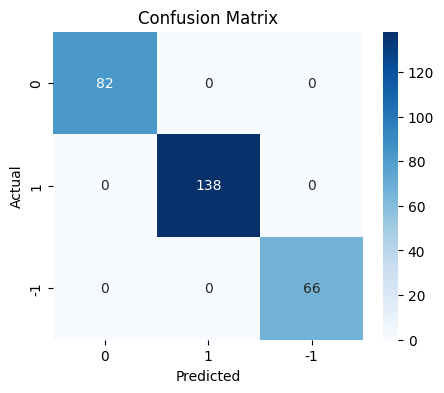

In [ ]:
plot_confusion_matrix(base_gl, X_train_gl, y_train)

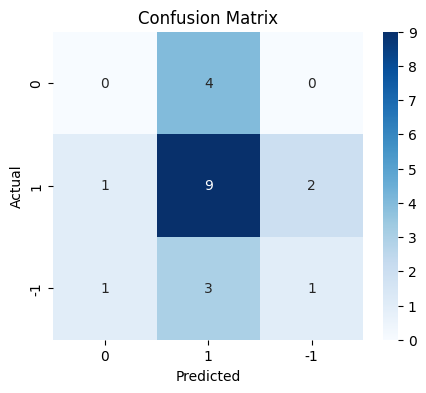

In [ ]:
plot_confusion_matrix(base_gl, X_val_gl, y_val)

In [ ]:
# Calculate various metrics on training data
base_train_gl = model_performance_classification_sklearn(base_gl, X_train_gl, y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
# Calculate various metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl, X_val_gl, y_val)
print("Validation performance:\n", base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


Observations:
- Model is overfitting the training data.
- Low F1 score on validation data.

### Base Model - Sentence Transformer

In [ ]:
# Build the model
base_st = RandomForestClassifier(random_state=42)

# Fit on training data
base_st.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

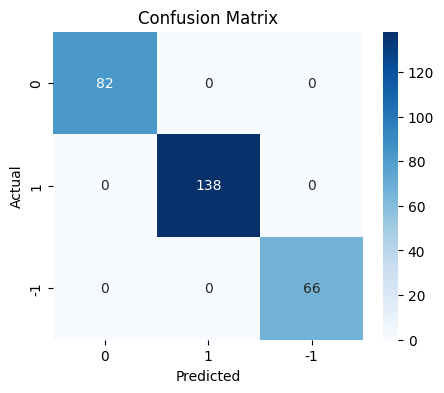

In [ ]:
plot_confusion_matrix(base_st, X_train_st, y_train)

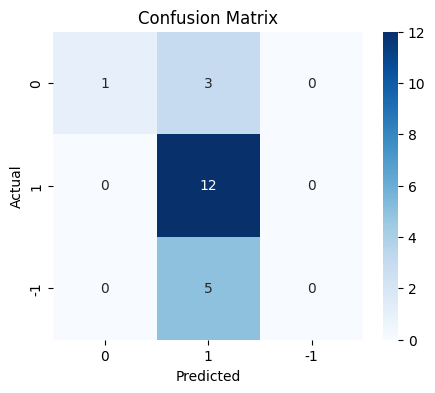

In [ ]:
plot_confusion_matrix(base_st, X_val_st, y_val)

In [ ]:
# Calculate various metrics on training data
base_train_st = model_performance_classification_sklearn(base_st, X_train_st, y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
# Calculate various metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st, X_val_st, y_val)
print("Validation performance:\n", base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.533333  0.504762


Observations:
- Model is overfitting the training data.
- Low F1 score on validation data.
- F1 score on validation data is better than what we got for Word2Vec and GloVe based models.

### Tuned Model - Word2Vec

In [ ]:
start = time.time()

tuned_wv = RandomForestClassifier(random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    'max_depth': np.arange(3, 7),
    'min_samples_split': np.arange(5, 12, 2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring=scorer, cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken:",(end - start))

# Set the model to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken: 147.1771855354309


In [ ]:
# Fit the best model to the training data
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_split=5,
                       random_state=42)

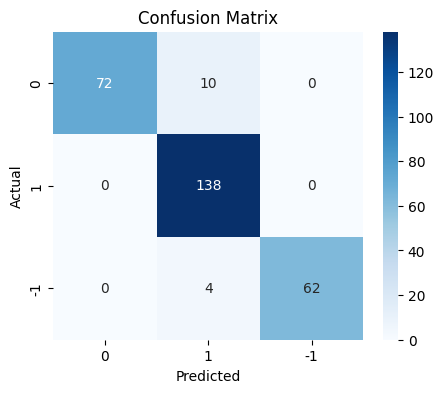

In [ ]:
plot_confusion_matrix(tuned_wv, X_train_wv, y_train)

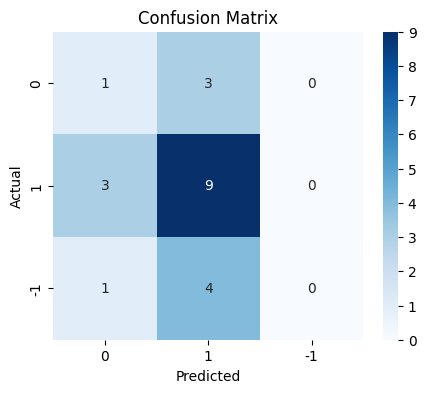

In [ ]:
plot_confusion_matrix(tuned_wv, X_val_wv, y_val)

In [ ]:
# Calculate various metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv, X_train_wv, y_train)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.951049  0.951049   0.955558  0.950877


In [ ]:
# Calculate various metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv, X_val_wv, y_val)
print("Validation performance:\n", tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.359524  0.409675


### Tuned Model - GloVe

In [ ]:
start = time.time()

tuned_gl = RandomForestClassifier(random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    'max_depth': np.arange(3, 7),
    'min_samples_split': np.arange(5, 12, 2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring=scorer, cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken:",(end - start))

# Set the model to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken: 85.14643001556396


In [ ]:
# Fit the best model to the training data
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

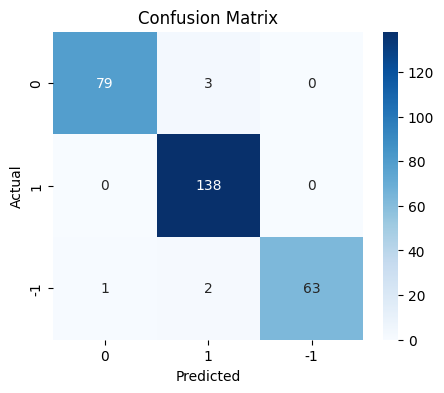

In [ ]:
plot_confusion_matrix(tuned_gl, X_train_gl, y_train)

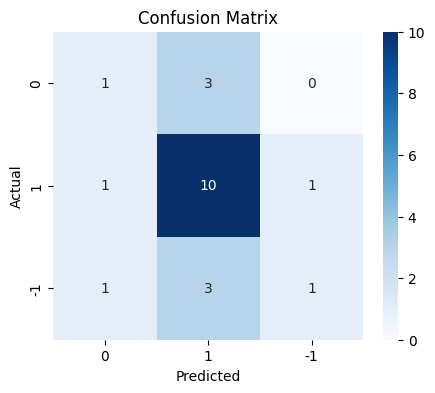

In [ ]:
plot_confusion_matrix(tuned_gl, X_val_gl, y_val)

In [ ]:
# Calculate various metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl, X_train_gl, y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [ ]:
# Calculate various metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl, X_val_gl, y_val)
print("Validation performance:\n", tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


### Tuned Model - Sentence Transformer

In [ ]:
start = time.time()

tuned_st = RandomForestClassifier(random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    'max_depth': np.arange(3, 7),
    'min_samples_split': np.arange(5, 12, 2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring=scorer, cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken:",(end - start))

# Set the model to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken: 170.12995648384094


In [ ]:
# Fit the best model to the training data
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=11,
                       random_state=42)

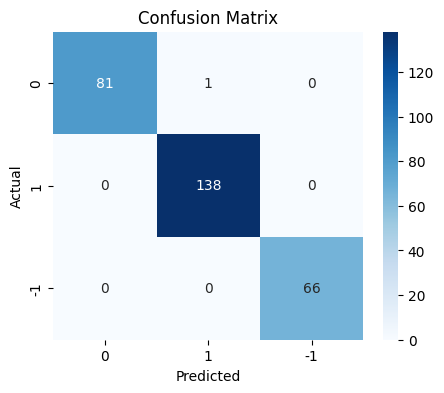

In [ ]:
plot_confusion_matrix(tuned_st, X_train_st, y_train)

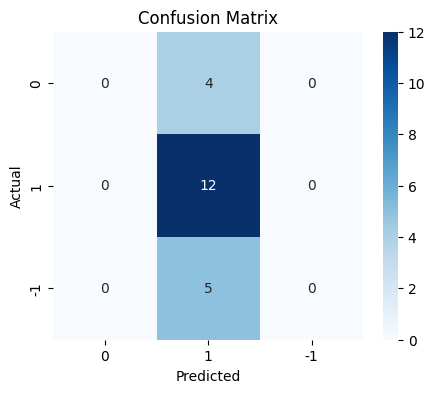

In [ ]:
plot_confusion_matrix(tuned_st, X_val_st, y_val)

In [ ]:
# Calculate various metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st, X_train_st, y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996503  0.996503   0.996529  0.996499


In [ ]:
# Calculate various metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st, X_val_st, y_val)
print("Validation performance:\n", tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


### Model Performance Summary and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.951049,0.979021,0.996503
Recall,1.0,1.0,1.0,0.951049,0.979021,0.996503
Precision,1.0,1.0,1.0,0.955558,0.979545,0.996529
F1,1.0,1.0,1.0,0.950877,0.978968,0.996499


In [ ]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.190476,0.476190,0.619048,0.476190,0.571429,0.571429
Recall,0.190476,0.476190,0.619048,0.476190,0.571429,0.571429
Precision,0.175824,0.400794,0.533333,0.359524,0.539683,0.326531
F1,0.182857,0.426871,0.504762,0.409675,0.530612,0.415584


- Based on the above performance comparision, we will go ahead and use the Tuned Model with GloVe Word Embeddings.

### Model Performance Check on Test Data

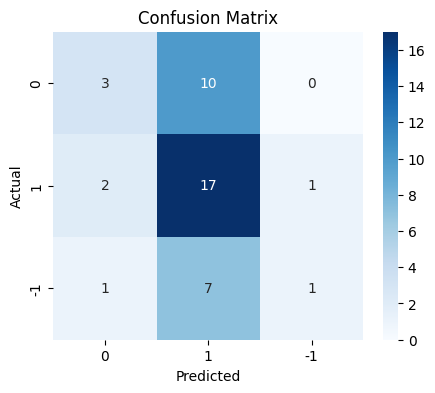

In [ ]:
plot_confusion_matrix(tuned_gl, X_test_gl, y_test)

In [ ]:
# Calculate various metrics on test data
final_model_test = model_performance_classification_sklearn(tuned_gl, X_test_gl, y_test)
print("Test performance for the final model:\n", final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5        0.5  0.436529


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 tqdm --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 208.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 260.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 288.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 256.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 314.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.1 which is incompatible.
langchain 0.3.12 requ

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd
import numpy as np

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stock_news = pd.read_csv('/content/drive/MyDrive/PG_AIML/NLP/Project_StockSentimentAnalysis/stock_news.csv')

In [ ]:
df = stock_news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [ ]:
df["Date"] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = df.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped.head()

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...


In [ ]:
# creating a copy of the data
data = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
# Defining the response function
def response_mistral(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News headline: {news}
      [/INST]
      """,
      max_tokens=1024,
      temperature=0.01,
      top_p=0.95,
      top_k=50,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = data.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
print(news)

2611
 The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
prompt = """
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and identify the top three positive and negative events that are likely to impact the stock price.

Instructions:
1. Read the news headline carefully.
2. Identify and summarize the top three positive events mentioned in the headline that are likely to impact the stock price.
3. Identify and summarize the top three negative events mentioned in the headline that are likely to impact the stock price.

Return the output in JSON format with keys as the positive or negative event type and values as the event summary.
"""

In [ ]:
%%time
summary = response_mistral(prompt, news)
print(summary)

Llama.generate: prefix-match hit


 {
         "positive_events": [
           {
             "event": "Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
             "summary": "Roku's announcement of offering premium video channels on a subscription basis through its free streaming service could positively impact Apple as it also follows Amazon's successful Channels business model."
           },
           {
             "event": "FDIC Chair expresses no concern over market volatility affecting the U.S banking system.",
             "summary": "The FDIC Chair's statement of no concern over market volatility affecting the U.S banking system could instill confidence in investors and potentially stabilize the stock market."
           },
           {
             "event": "Chinese central bank announces a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending.",
     

##### Checking the model output on the weekly data

In [ ]:
%%time
data['Key Events'] = data['News'].progress_apply(lambda x: response_mistral(prompt, x))

100%|██████████| 18/18 [08:31<00:00, 28.43s/it]

CPU times: user 7min 58s, sys: 27.9 s, total: 8min 26s
Wall time: 8min 31s


In [ ]:
data.head()

,Date,News,Key Events
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""positive_events"": [\n ..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""positive_events"": [\n ..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""positive_events"": [\n ..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""positive_events"": [\n ..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""positive_events"": [\n ..."


##### Formatting the model output

In [ ]:
data['model_response_parsed'] = data['Key Events'].apply(extract_json_data)
data.head()

Error parsing JSON: Expecting property name enclosed in double quotes: line 20 column 12 (char 1670)
Error parsing JSON: Expecting property name enclosed in double quotes: line 20 column 12 (char 1569)


,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""positive_events"": [\n ...",{'positive_events': [{'event': 'Roku Inc annou...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""positive_events"": [\n ...",{'positive_events': [{'event': 'Sprint and Sam...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""positive_events"": [\n ...",{'positive_events': [{'event': 'Netflix announ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""positive_events"": [\n ...",{'positive_events': [{'event': 'IBM's stock pr...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""positive_events"": [\n ...",{'positive_events': [{'event': 'Apple reported...


- 2 rows are not being parsed correctly as JSON as the model response has invalid characters present in those rows. Excluding those 2 weeks data for now.

In [ ]:
model_response_parsed = pd.json_normalize(data['model_response_parsed'])
model_response_parsed.head()

,positive_events,negative_events
0,[{'event': 'Roku Inc announces plans to offer ...,[{'event': 'Apple lowers its fiscal Q1 revenue...
1,[{'event': 'Sprint and Samsung plan to release...,[{'event': 'Geely forecasts flat sales for 201...
2,[{'event': 'Netflix announced a price increase...,[{'event': 'Unexpected drops in China's export...
3,[{'event': 'IBM's stock price increase due to ...,[{'event': 'Swiss National Bank governor empha...
4,[{'event': 'Apple reported spending over $60 b...,[{'event': 'Caterpillar Inc reported lower-tha...


In [ ]:
final_output = pd.concat([data.reset_index(drop=True), model_response_parsed], axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

In [ ]:
pd.set_option('display.max_colwidth', 1000)
final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. || Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 || Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon || This news article reports that yields on...","[{'event': 'Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.', 'summary': 'Roku's announcement of offering premium video channels on a subscription basis through its free streaming service could positively impact Apple as it also follows Amazon's successful Channels business model.'}, {'event': 'FDIC Chair expresses no concern over market volatility affecting the U.S banking system.', 'summary': 'The FDIC Chair's statement of no concern over market volatility affecting the U.S banking system could instill confidence in investors and potentially stabilize the stock market.'}, {'event': 'Chinese central bank announces a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending.', 'summary': 'The Chinese central bank's decision to reduce the RRR could stimulate economic growth and potentially improve demand for Apple products in China.'}]","[{'event': 'Apple lowers its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales.', 'summary': 'Apple's revenue warning and the subsequent decline in its stock price could negatively impact related suppliers, leading to broader market declines for tech indices such as Nasdaq 100.'}, {'event': 'Investors' concerns about a slowing Chinese and global economy amplified by Apple's revenue warning led to significant losses in the US stock market.', 'summary': 'The US stock market's significant declines following Apple's revenue warning could negatively impact investor sentiment and potentially lead to further selling of Apple shares.'}, {'event': 'Oil prices dropped on Thursday as investor sentiment remained affected by China's economic slowdown and turmoil in stock and currency markets.', 'summary': 'The decline in oil prices due to concerns over China's economic slowdown could negatively impact Apple's revenue, pa..."
1,2019-01-13,"Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer, with Atlanta, Chicago, Dallas, Houston, Kansas City, Los Angeles, New York City, Phoenix, and Washington D.C. being the initial locations. Rival Verizon also announced similar plans for the first half of 20 || AMS, an Austrian tech company listed in Switzerland and a major supplier to Apple, has developed a light and infrared proximity sensor that can be placed behind a smartphone's screen. This allows for a larger display area by reducing the required space for sensors. AMS provides optical sensors for 3D facial recognition features on Apple || Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion, surpassing the market cap of Vivendi at €28.3 billion. The bank anticipates music streaming revenue to reach €21 billion in 2023 and identifies potential suitors for || Amazon's

## **Conclusions and Recommendations**

**Conclusions:**
- The tuned RandomForestClassifier with GloVe embeddings demonstrated the best overall performance, achieving a higher F1-score on the validation set compared to other models (Word2Vec, Sentence Transformer) and their respective baseline scores. Tuning improved the performance, particularly in reducing overfitting. However, a performance gap between training and validation sets persisted.
- GloVe embeddings appear most effective for sentiment classification in this context, potentially due to their ability to capture semantic relationships between words more effectively than Word2Vec for this specific dataset. The Sentence Transformer, while promising, might require further fine-tuning.
- The final model's test F1 score is comparable to the validation set F1 score which suggests that it's a generalized model. However, the score is relatively low at ~50% and could be further improved by using a larger training set and further hyperparameter tuning.
- With News Summarization, the LLM generally produced relevant summaries, but Prompt engineering can be further explored to elicit more specific and actionable summaries. Alternative strategies to handle the 2 malformed JSON responses or a more robust JSON parsing method should be explored.

**Recommendations:**
- The output model from the sentiment analysis and the news summaries could potentially inform investment decisions, risk assessment, and market trend analysis. Integration of the system with other data sources and real-time news feeds can potentially lead to better business decision-making.
- For sentiment analysis, explore alternative algorithms like deep learning models, (e.g., learning rate, regularization parameters) to enhance the scores.
- Implement more robust error handling, especially for the JSON parsing step in the news summarization process to prevent data loss and ensure better overall performance.
- Refine the LLM prompt or explore different LLMs or fine-tune an existing model to improve the summarization process.


<font size=6 color='blue'>Power Ahead</font>
___